# Analyzing Which Feeds need pathways.txt 

Request from Ruth. 

1. Assume every system with a route type other than bus has at least some stations worth including. So create a list of all feeds with non-bus route types, indicating what route types they have.
2. Assume next that places with many stops and many agencies would be pertinent. So create a list of places where there are stops from more than two agencies in close proximity (<10 m). Sort the list by number of agencies, and we'll investigate working our way down the list.

In [1]:
import pandas as pd
import geopandas as gpd
import tqdm

In [2]:
# remember to set project at Gcloud command line level to `cal-itp-data-infra` otherwise this will fail
import gcsfs
fs = gcsfs.GCSFileSystem()

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1qr49azk6p30mp96_7myKoO-Bb_bXMMn5ZzgbL-uPiPw/gviz/tq?tqx=out:csv&sheet=Data')

# Collect all the routes files

In [4]:
routes = {}
for agency_path in fs.ls('gtfs-data/schedule/2021-03-04T00:00:00+00:00'):
    itp_id = agency_path.split('/')[-1]
    route = pd.read_csv(f'gcs://{agency_path}/routes.txt')    
    routes[itp_id] = route

In [5]:
conversion_dict = {0: 'Light Rail', 1: "Subway", 2: "Rail", 3: "Bus", 4: "Ferry", 5: "Cable Tram", 6: "Aerial Lift", 7: "Funicular", 11: "Trolleybus", 12: "Monorail"}

In [6]:
routes_name = {}
for agency in routes:
    name = df[df.ITP_ID == int(agency)]['Agency Name'].values[0]
    routes_name[name] = routes[agency]

Determine which ones operate non-bus ones 

In [7]:
print("The Following Agencies in our List have non-bus transit")
for agency in routes_name: 
    try:
        other_form_list = list(routes_name[agency].route_type.replace(conversion_dict).unique()).remove('Bus')
    except ValueError: 
        other_form_list = list(routes_name[agency].route_type.replace(conversion_dict).unique())
    if other_form_list:
        print(f"{agency}: {other_form_list}")

The Following Agencies in our List have non-bus transit
Bay Area Rapid Transit: ['Subway']
San Francisco Bay Ferry: ['Ferry']
Sonoma-Marin Area Rail Transit: ['Rail']
Tideline: ['Ferry']


## Stops under 10M apart

In [8]:
stops = {}
for agency_path in fs.ls('gtfs-data/schedule/2021-03-04T00:00:00+00:00'):
    itp_id = agency_path.split('/')[-1]
    stop = pd.read_csv(f'gcs://{agency_path}/stops.txt')    
    stops[itp_id] = stop

In [9]:
stops_named = {}
for agency in stops:
    name = df[df.ITP_ID == int(agency)]['Agency Name'].values[0]
    stops_named[name] = stops[agency]

In [10]:
dfs = []
for agency in stops_named:
    t_df = stops_named[agency][['stop_lat','stop_lon']].assign(agency = agency)
    dfs.append(t_df)

In [11]:
df = pd.concat(dfs)

In [12]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.stop_lon, df.stop_lat))

<AxesSubplot:>

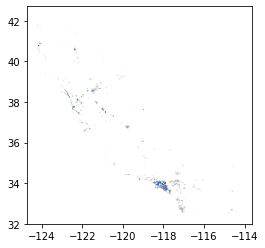

In [15]:
# .001 degrees is close enough for 10 metrs for intersecting purposes
small_gdf = gdf.assign(geometry=gdf.buffer(.001)).dissolve(by='agency')
small_gdf.plot()

In [16]:
for agency in tqdm.tqdm(small_gdf.iterrows()):
    agency_name = agency[0]
    geometry = agency[1]['geometry']
    other_agency_geom = small_gdf[small_gdf.index != agency_name].unary_union
    print(f"Does {agency_name} have a stop close to another agency? {geometry.intersects(other_agency_geom)}")

1it [01:17, 77.34s/it]

Does Alhambra Community Transit have a stop close to another agency? True


2it [02:35, 77.53s/it]

Does Amador Regional Transit System have a stop close to another agency? True


3it [04:03, 80.70s/it]

Does Anaheim Resort Transportation have a stop close to another agency? True


4it [05:14, 77.93s/it]

Does Arcadia Transit have a stop close to another agency? False


5it [06:23, 75.04s/it]

Does Arcata and Mad River Transit System have a stop close to another agency? True


6it [07:33, 73.57s/it]

Does Arvin Transit have a stop close to another agency? True


7it [08:46, 73.43s/it]

Does Auburn Transit have a stop close to another agency? True


8it [10:00, 73.50s/it]

Does Avalon Transit have a stop close to another agency? False


9it [13:02, 106.13s/it]

Does Avocado Heights/Bassett/West Valinda Shuttle have a stop close to another agency? True


10it [14:12, 95.29s/it]

Does Baldwin Park Transit have a stop close to another agency? True


11it [15:52, 96.85s/it]

Does Banning Pass Transit have a stop close to another agency? True


12it [17:19, 93.92s/it]

Does Bay Area Rapid Transit have a stop close to another agency? True


13it [18:55, 94.33s/it]

Does Bear Transit have a stop close to another agency? True


14it [20:42, 98.33s/it]

Does Beaumont Pass Transit have a stop close to another agency? True


15it [22:37, 103.20s/it]

Does Bell Gardens have a stop close to another agency? True


16it [24:23, 104.13s/it]

Does Bellflower Bus have a stop close to another agency? True


17it [28:17, 142.96s/it]

Does Big Blue Bus have a stop close to another agency? True


18it [30:22, 137.65s/it]

Does Blossom Express have a stop close to another agency? True


19it [32:07, 127.97s/it]

Does Blue Lake Rancheria have a stop close to another agency? True


20it [34:16, 128.20s/it]

Does Burbank Bus have a stop close to another agency? True


21it [36:32, 130.53s/it]

Does Burney Express have a stop close to another agency? True


22it [38:10, 120.80s/it]

Does Calabasas Transit System have a stop close to another agency? True


23it [39:28, 107.76s/it]

Does Calaveras Transit have a stop close to another agency? True


24it [40:39, 96.87s/it] 

Does Caltrain have a stop close to another agency? True


25it [42:00, 92.18s/it]

Does Camarillo Area Transit have a stop close to another agency? True


26it [43:29, 91.06s/it]

Does Capitol Corridor have a stop close to another agency? True


27it [45:07, 93.09s/it]

Does Carson Circuit have a stop close to another agency? True


28it [46:45, 94.67s/it]

Does Ceres Area Transit have a stop close to another agency? True


29it [48:33, 98.58s/it]

Does Cloverdale Transit have a stop close to another agency? True


30it [52:38, 142.69s/it]

Does Clovis Transit System have a stop close to another agency? True


31it [54:14, 128.47s/it]

Does Commerce Municipal Bus Lines have a stop close to another agency? True


32it [56:24, 129.01s/it]

Does Commuter Express have a stop close to another agency? True


33it [57:51, 116.44s/it]

Does Compton Renaissance Transit Service have a stop close to another agency? True


34it [59:06, 104.08s/it]

Does Corona Cruiser have a stop close to another agency? True


35it [1:00:28, 97.35s/it]

Does County Connection have a stop close to another agency? True


36it [1:01:55, 94.26s/it]

Does County Express have a stop close to another agency? True


37it [1:03:43, 98.45s/it]

Does Cudahy Area Rapid Transit have a stop close to another agency? False


38it [1:05:32, 101.71s/it]

Does DASH have a stop close to another agency? True


39it [1:07:17, 102.53s/it]

Does Delano Area Rapid Transit have a stop close to another agency? True


40it [1:08:53, 100.48s/it]

Does Desert Roadrunner have a stop close to another agency? True


41it [1:10:15, 95.12s/it] 

Does DowneyLINK have a stop close to another agency? True


42it [1:11:49, 94.70s/it]

Does Duarte Transit have a stop close to another agency? False


43it [1:14:42, 118.13s/it]

Does East Los Angeles Shuttle have a stop close to another agency? True


44it [1:17:52, 139.78s/it]

Does East Valinda Shuttle have a stop close to another agency? True


45it [1:20:26, 144.15s/it]

Does Eastern Sierra Transit Authority have a stop close to another agency? True


46it [1:23:28, 155.49s/it]

Does El Dorado Transit have a stop close to another agency? True


47it [1:26:11, 157.72s/it]

Does El Monte Transportation Division have a stop close to another agency? True


48it [1:27:23, 132.08s/it]

Does Emery Go-Round have a stop close to another agency? True


49it [1:28:41, 115.74s/it]

Does Eureka Transit Service have a stop close to another agency? True


50it [1:31:58, 140.09s/it]

Does Fairfield and Suisun Transit have a stop close to another agency? True


51it [1:34:45, 148.28s/it]

Does Folsom Stage Line have a stop close to another agency? True


52it [1:36:46, 140.13s/it]

Does Fresno Area Express have a stop close to another agency? True


53it [1:40:10, 159.29s/it]

Does GTrans have a stop close to another agency? True


54it [1:41:36, 137.09s/it]

Does Glendora Transportation Division have a stop close to another agency? True


55it [1:43:18, 126.61s/it]

Does Go West Shuttle have a stop close to another agency? True


56it [1:44:58, 118.72s/it]

Does Gold Coast Transit have a stop close to another agency? True


57it [1:48:06, 139.41s/it]

Does Golden Gate Bridge Highway and Transportation District have a stop close to another agency? True


58it [1:49:30, 122.90s/it]

Does Guadalupe Flyer have a stop close to another agency? True


59it [1:50:50, 110.04s/it]

Does Humboldt Transit Authority have a stop close to another agency? True


60it [1:52:20, 103.84s/it]

Does Huntington Park Express have a stop close to another agency? True


61it [1:54:10, 105.77s/it]

Does Irvine Shuttle have a stop close to another agency? True


62it [1:55:32, 98.60s/it] 

Does Kern Transit have a stop close to another agency? True


63it [1:56:42, 90.15s/it]

Does La Campana have a stop close to another agency? True


64it [1:58:02, 87.10s/it]

Does Laguna Beach Municipal Transit have a stop close to another agency? True


65it [1:59:14, 82.46s/it]

Does Lake Transit have a stop close to another agency? True


66it [2:00:20, 77.65s/it]

Does Lassen Transit Service Agency have a stop close to another agency? True


67it [2:01:30, 75.19s/it]

Does Lawndale Beat have a stop close to another agency? True


68it [2:03:59, 97.50s/it]

Does Lincoln Transit have a stop close to another agency? True


69it [2:05:56, 103.28s/it]

Does Long Beach Transit have a stop close to another agency? True


70it [2:07:24, 98.58s/it] 

Does MUNI have a stop close to another agency? True


71it [2:08:38, 91.28s/it]

Does MVGO have a stop close to another agency? True


72it [2:09:59, 88.33s/it]

Does Madera Area Express have a stop close to another agency? True


73it [2:11:36, 90.77s/it]

Does Madera County Connection have a stop close to another agency? True


74it [2:14:43, 119.62s/it]

Does Mammoth Lakes Transit System have a stop close to another agency? True


75it [2:16:07, 109.14s/it]

Does Marguerite Shuttle have a stop close to another agency? True


76it [2:17:32, 101.74s/it]

Does Marin Transit have a stop close to another agency? True


77it [2:21:48, 147.95s/it]

Does Mendocino Transit Authority have a stop close to another agency? True


78it [2:24:11, 146.65s/it]

Does Menlo Park Shuttles have a stop close to another agency? True


79it [2:26:22, 141.84s/it]

Does Merced The Bus have a stop close to another agency? True


80it [2:29:01, 146.89s/it]

Does Metrolink have a stop close to another agency? True


81it [2:30:49, 135.28s/it]

Does Mission Bay TMA have a stop close to another agency? True


82it [2:32:43, 128.83s/it]

Does Modesto Area Express have a stop close to another agency? True


83it [2:37:34, 177.51s/it]

Does Montebello Bus Lines have a stop close to another agency? True


84it [2:39:59, 167.79s/it]

Does Monterey-Salinas Transit have a stop close to another agency? True


85it [2:41:45, 149.33s/it]

Does Moorpark City Transit have a stop close to another agency? True


86it [2:46:20, 186.99s/it]

Does Morongo Basin Transit Authority have a stop close to another agency? True


87it [2:47:55, 159.33s/it]

Does Morro Bay Transit have a stop close to another agency? False


88it [2:49:42, 143.71s/it]

Does Needles Area Transit have a stop close to another agency? True


89it [2:51:50, 139.09s/it]

Does North County Transit District have a stop close to another agency? True


90it [2:56:22, 178.96s/it]

Does Norwalk Transit System have a stop close to another agency? True


91it [3:01:07, 210.82s/it]

Does OmniTrans have a stop close to another agency? True


92it [3:03:22, 187.95s/it]

Does Orange County Transportation Authority have a stop close to another agency? True


93it [3:07:46, 210.62s/it]

Does Palos Verdes Peninsula Transit Authority have a stop close to another agency? True


94it [3:10:23, 194.69s/it]

Does Petaluma Transit have a stop close to another agency? True


95it [3:13:13, 187.19s/it]

Does Placer County Transit have a stop close to another agency? True


96it [3:14:40, 157.29s/it]

Does Plumas Transit Systems have a stop close to another agency? True


97it [3:16:17, 139.05s/it]

Does Porterville Transit have a stop close to another agency? False


98it [3:17:29, 119.09s/it]

Does Redding Area Bus Authority have a stop close to another agency? True


99it [3:19:57, 127.69s/it]

Does Redwood Coast Transit have a stop close to another agency? True


100it [3:21:07, 110.31s/it]

Does Ridgecrest Transit have a stop close to another agency? True


101it [3:22:15, 97.60s/it] 

Does Rio Vista Delta Breeze have a stop close to another agency? True


102it [3:23:58, 99.44s/it]

Does Riverside Transit Agency have a stop close to another agency? True


103it [3:25:20, 94.08s/it]

Does Rosemead Explorer have a stop close to another agency? True


104it [3:28:15, 118.42s/it]

Does Roseville Transit have a stop close to another agency? True


105it [3:29:37, 107.33s/it]

Does Sacramento Regional Transit District have a stop close to another agency? True


106it [3:30:47, 96.27s/it] 

Does Sage Stage have a stop close to another agency? True


107it [17:29:24, 15162.51s/it]

Does SamTrans have a stop close to another agency? True


108it [17:31:30, 10651.52s/it]

Does San Diego Metropolitan Transit System have a stop close to another agency? True


109it [17:32:35, 7475.50s/it] 

Does San Francisco Bay Ferry have a stop close to another agency? True


110it [17:33:46, 5254.09s/it]

Does San Joaquin Regional Transit District have a stop close to another agency? True


111it [17:35:11, 3703.47s/it]

Does San Juan Capistrano Free Weekend Trolley have a stop close to another agency? True


112it [17:36:20, 2613.21s/it]

Does Santa Barbara Metropolitan Transit District have a stop close to another agency? True


113it [17:37:30, 1850.23s/it]

Does Santa Cruz Metropolitan Transit District have a stop close to another agency? True


114it [17:39:50, 1337.06s/it]

Does Santa Maria Area Transit have a stop close to another agency? True


115it [17:40:54, 955.22s/it] 

Does Santa Ynez Valley Transit have a stop close to another agency? True


116it [17:43:13, 710.32s/it]

Does Simi Valley Transit have a stop close to another agency? True


117it [17:45:33, 539.32s/it]

Does Siskiyou Transit and General Express have a stop close to another agency? False


118it [17:46:38, 396.79s/it]

Does SolTrans have a stop close to another agency? True


119it [17:47:42, 297.01s/it]

Does SolanoExpress have a stop close to another agency? True


120it [17:49:06, 233.22s/it]

Does Sonoma County Transit have a stop close to another agency? True


121it [17:50:29, 188.01s/it]

Does Sonoma-Marin Area Rail Transit have a stop close to another agency? True


122it [17:51:33, 151.00s/it]

Does South County Transit Link have a stop close to another agency? True


123it [17:52:41, 125.93s/it]

Does Spirit Bus have a stop close to another agency? True


124it [17:53:54, 110.12s/it]

Does Stanislaus Regional Transit have a stop close to another agency? True


125it [17:56:34, 125.07s/it]

Does SunLine Transit Agency have a stop close to another agency? True


126it [17:58:51, 128.62s/it]

Does Sunshine Bus(South Whittier) have a stop close to another agency? True


127it [17:59:56, 109.69s/it]

Does Susanville Indian Rancheria Public Transportation Program have a stop close to another agency? True


128it [18:08:59, 239.70s/it]

Does Tahoe Transportation have a stop close to another agency? True


129it [18:13:56, 256.77s/it]

Does Tahoe Truckee Area Regional Transportation have a stop close to another agency? True


130it [18:16:09, 219.62s/it]

Does Tehama Rural Area eXpress have a stop close to another agency? True


131it [18:21:00, 240.97s/it]

Does Thousand Oaks Transit have a stop close to another agency? True


132it [18:23:09, 207.34s/it]

Does Tideline have a stop close to another agency? True


133it [18:25:09, 181.30s/it]

Does Trinity Transit have a stop close to another agency? True


134it [18:27:16, 165.08s/it]

Does Turlock Transit have a stop close to another agency? True


135it [18:29:34, 156.99s/it]

Does Union City Transit have a stop close to another agency? True


136it [18:35:01, 207.88s/it]

Does Unitrans have a stop close to another agency? True


137it [18:39:33, 227.05s/it]

Does Vacaville City Coach have a stop close to another agency? True


138it [18:43:47, 235.04s/it]

Does Ventura County Transportation Commission have a stop close to another agency? True


139it [18:46:17, 209.69s/it]

Does Victor Valley Transit have a stop close to another agency? True


140it [18:48:45, 191.16s/it]

Does Vine Transit have a stop close to another agency? True


141it [18:53:20, 216.40s/it]

Does WestCAT have a stop close to another agency? True


142it [18:55:38, 192.92s/it]

Does Yolobus have a stop close to another agency? True


143it [18:59:46, 209.45s/it]

Does Yosemite Area Regional Transportation System have a stop close to another agency? True


144it [19:01:43, 181.54s/it]

Does Yuba-Sutter Transit Authority have a stop close to another agency? True


145it [19:04:10, 171.20s/it]

Does Yuma County Area Transit have a stop close to another agency? False


146it [19:07:32, 180.44s/it]

Does the Link Florence-Firestone/Walnut Park have a stop close to another agency? True


147it [19:10:23, 177.53s/it]

Does the Link King Medical Center have a stop close to another agency? True


148it [19:13:07, 173.51s/it]

Does the Link Lennox have a stop close to another agency? True


149it [19:16:06, 175.17s/it]

Does the Link Willowbrook have a stop close to another agency? True


150it [19:19:17, 463.72s/it]

Does the Link-Athens have a stop close to another agency? True
